DATA: https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset/data


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [2]:
# Configuration
DATA_DIR = "C:/Project/Bloodcell/data/blood_cell_images"
IMAGE_SIZE = (224, 224)
BATCH_SIZE_EDA = 32
NUM_CLASSES = 8

In [3]:
# List classes and image paths
classes = sorted(os.listdir(DATA_DIR))
print(f"Classes: {classes}")

image_paths = []
labels = []
for i, class_name in enumerate(classes):
    class_dir = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(class_dir, img_name))
                labels.append(i)

print(f"Total images found: {len(image_paths)}")
if not image_paths:
    raise ValueError(f"No images found in {DATA_DIR}. Please check the path and dataset structure!")


Classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Total images found: 17092



Class Distribution: {'basophil': 1218, 'eosinophil': 3117, 'erythroblast': 1551, 'ig': 2895, 'lymphocyte': 1214, 'monocyte': 1420, 'neutrophil': 3329, 'platelet': 2348}


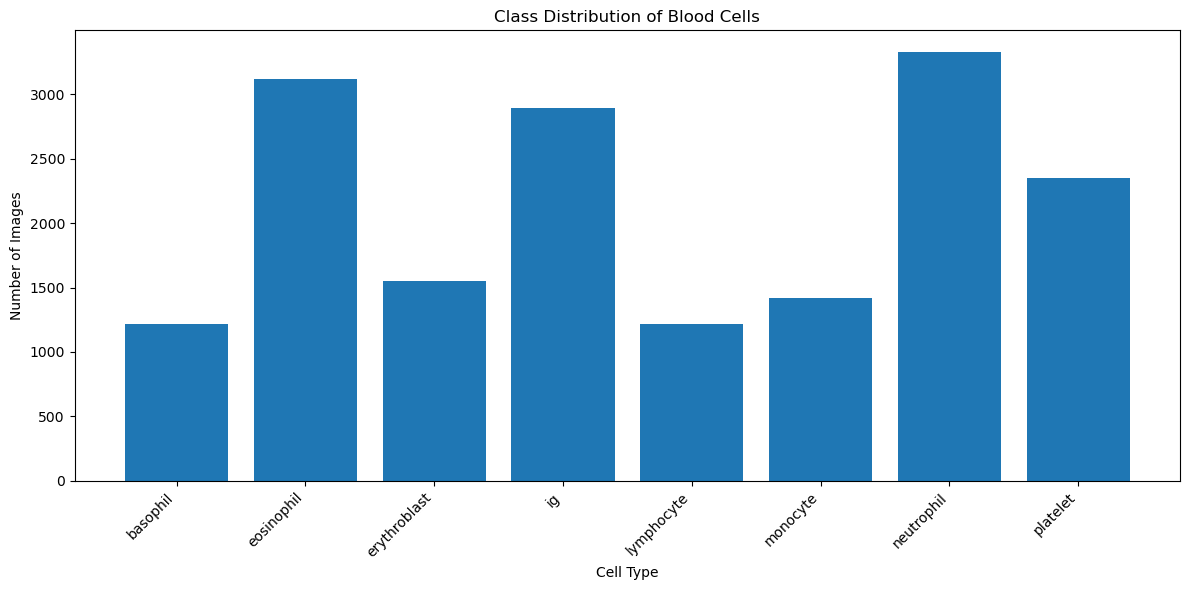

In [4]:
# Class Distribution
label_counts = Counter(labels)
class_names_counts = {classes[i]: count for i, count in label_counts.items()}
print(f"\nClass Distribution: {class_names_counts}")

plt.figure(figsize=(12, 6))
plt.bar(class_names_counts.keys(), class_names_counts.values())
plt.title("Class Distribution of Blood Cells")
plt.xlabel("Cell Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

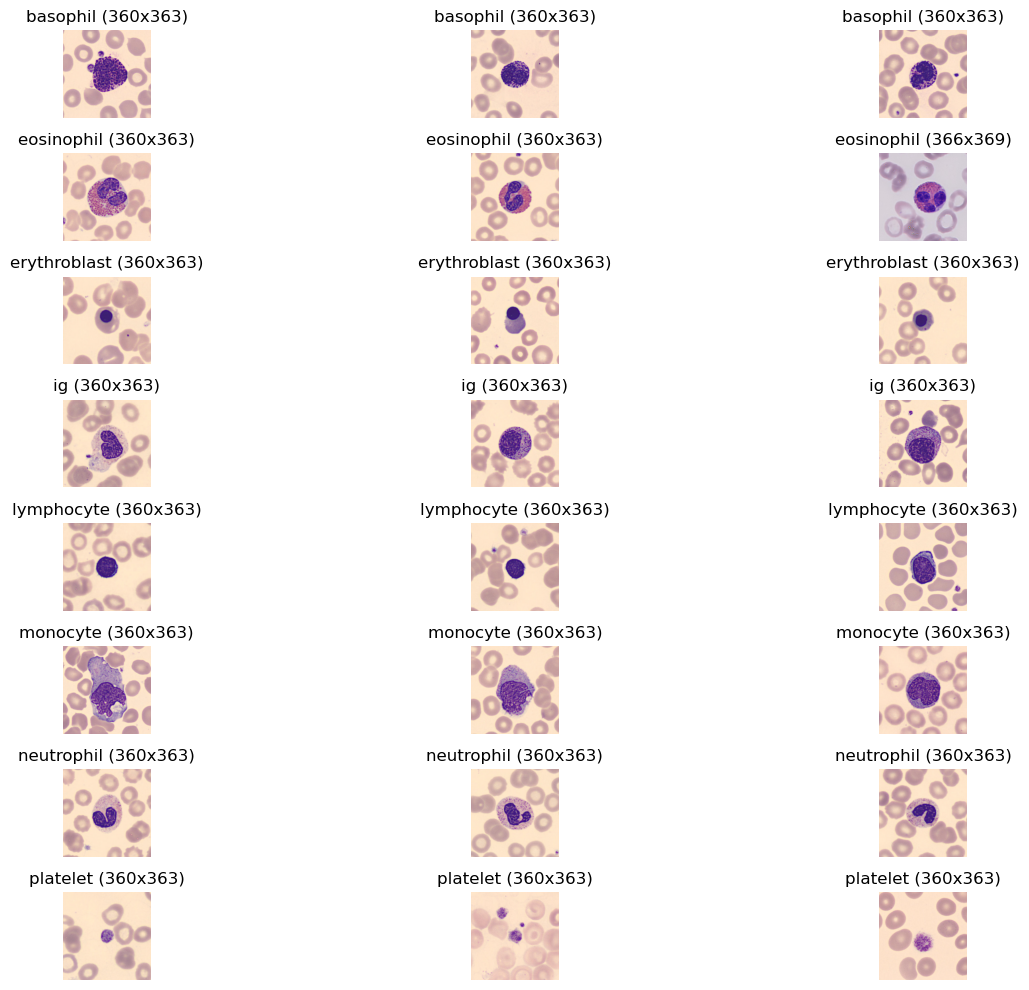

In [5]:
# Display sample image
def display_sample_images(num_samples_per_class=3):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(classes):
        class_images = [img_path for img_path, label_idx in zip(image_paths, labels) if label_idx == i]
        if not class_images:
            print(f"No images found for class: {class_name}")
            continue

        selected_images = np.random.choice(class_images, min(num_samples_per_class, len(class_images)), replace=False)

        for j, img_path in enumerate(selected_images):
            try:
                img = Image.open(img_path)
                plt.subplot(NUM_CLASSES, num_samples_per_class, i * num_samples_per_class + j + 1)
                plt.imshow(img)
                plt.title(f"{class_name} ({img.size[0]}x{img.size[1]})")
                plt.axis("off")
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    plt.tight_layout()
    plt.show()

display_sample_images()

## Data Preprocessing and Splitting Plan

In [6]:
temp_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])
print("\nCalculating mean and standard deviation...")
subset_indicies = np.random.choice(len(image_paths), size=min(2000, len(image_paths)), replace=False)
subset_image_paths = [image_paths[i] for i in subset_indicies]

imgs_tensor_list = []
for img_path in subset_image_paths:
    try:
        img = Image.open(img_path).convert("RGB")
        imgs_tensor_list.append(temp_transform(img))
    except Exception as e:
        print(f"Skipping image {img_path} due to error: {e}")
        continue

if not imgs_tensor_list:
    print("No images processed for mean/std calculation. Using default ImageNet stats.")
    dataset_mean = [0.485, 0.456, 0.406]
    dataset_std = [0.229, 0.224, 0.225]
else:
    imgs_stacked = torch.stack(imgs_tensor_list)
    dataset_mean = imgs_stacked.mean(dim=[0, 2, 3]).tolist()
    dataset_std = imgs_stacked.std(dim=[0, 2, 3]).tolist()

print(f"Calculating Mean: {dataset_mean}")
print(f"Calculating Std: {dataset_std}")


Calculating mean and standard deviation...
Calculating Mean: [0.8742497563362122, 0.7491484880447388, 0.7213816046714783]
Calculating Std: [0.15781086683273315, 0.1840810924768448, 0.07911773025989532]


## 6. PyTorch Dataset and DataLoader

In [7]:
full_dataset_raw = datasets.ImageFolder(DATA_DIR)

train_size = int(0.7 * len(full_dataset_raw))
val_size = int(0.15 * len(full_dataset_raw))
test_size = len(full_dataset_raw) - train_size - val_size

print(f"\nDataset sizes: Total={len(full_dataset_raw)}, Train={train_size}, Val={val_size}, Test={test_size}")


Dataset sizes: Total=17092, Train=11964, Val=2563, Test=2565


In [8]:
# Use a fixed generator for reproducibility of splits during EDA
train_dataset_raw, val_dataset_raw, test_dataset_raw = random_split(
    full_dataset_raw, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(46)
)

# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

In [9]:
# Applying transform is bit difficult so we will wrap a subset with new transforms. Basically we will make a custom dataset class
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.subset)

train_dataset = TransformedSubset(train_dataset_raw, transform=train_transforms)
val_dataset = TransformedSubset(val_dataset_raw, transform=val_test_transforms)
test_dataset = TransformedSubset(test_dataset_raw, transform=val_test_transforms)


In [10]:
# import time

# for nw in [0, 2, 4, 6]:
#     loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=nw, pin_memory=True)
#     start = time.time()
#     for i, (x, y) in enumerate(loader):
#         if i == 10: break
#     print(f"num_workers={nw}: {time.time() - start:.2f}s")


In [11]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_EDA, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_EDA, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_EDA, shuffle=False, pin_memory=True)

# Verify one batch
print("\nVerifying DataLoader...")
images, labels_batch = next(iter(train_loader))
print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels_batch.shape}")
print(f"Sample labels: {labels_batch[:5]}")


Verifying DataLoader...
Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Sample labels: tensor([1, 7, 3, 6, 5])


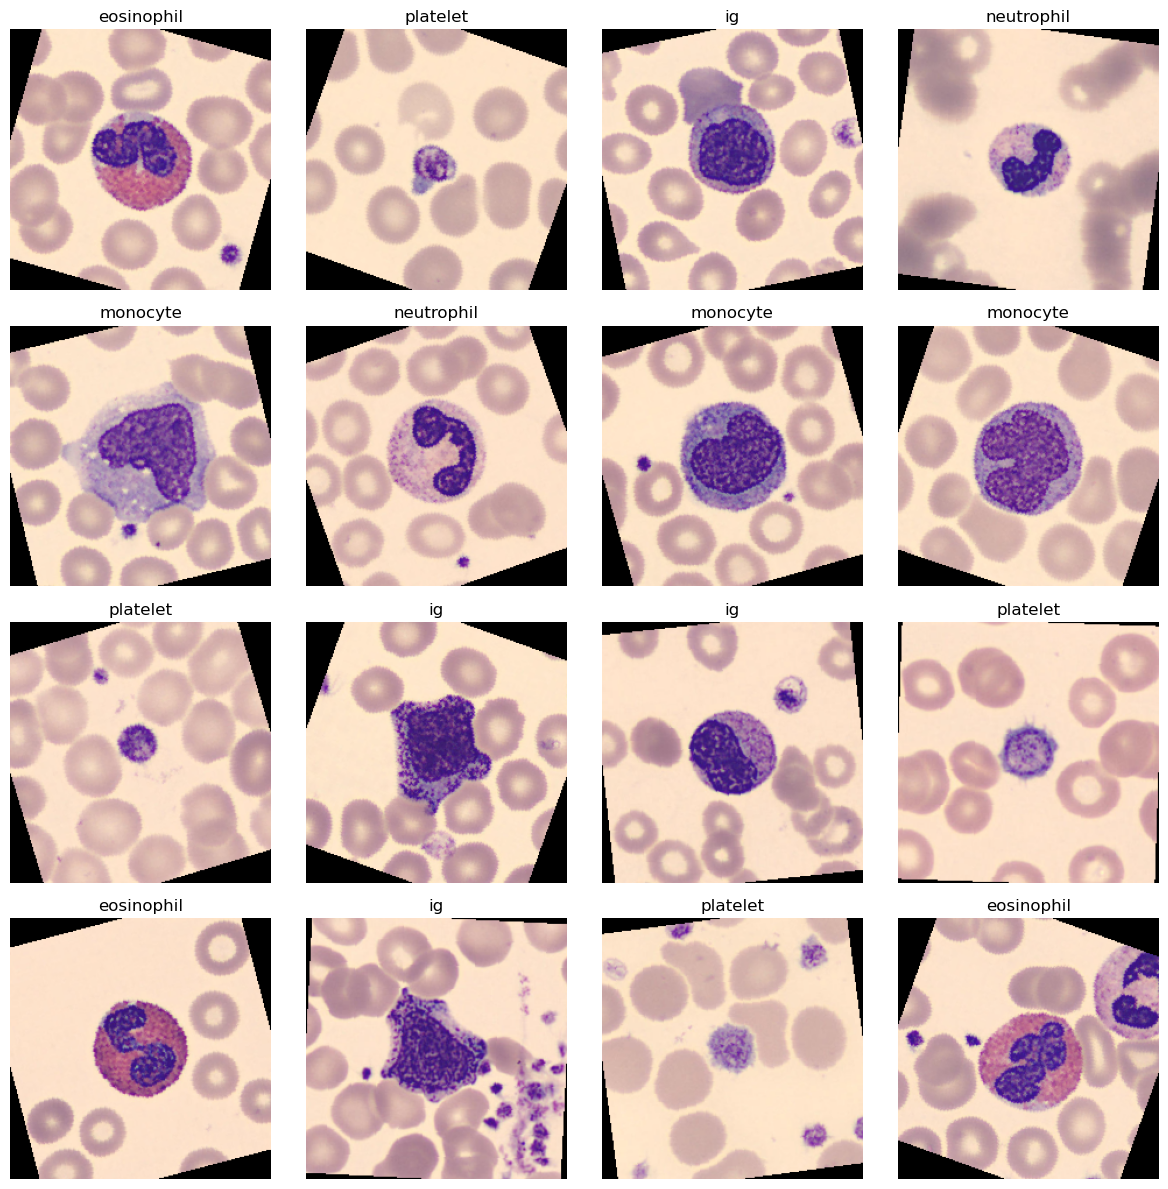


EDA and basic preprocessing setup complete.
Key takeaways:
- Image size for the model input: (224, 224)
- Number of classes: 8
- Calculated Mean for Normalisation: [0.8742497563362122, 0.7491484880447388, 0.7213816046714783]
- Calculated Std for Normalisation: [0.15781086683273315, 0.1840810924768448, 0.07911773025989532]
- Data splits: Train=11964, Val=2563, Test=2565
Next steps: Implement 'src/data_loader.py' based on this


In [14]:
# Display one batch of augmented images
def imshow_tensor(tensor_img, title=None, mean=None, std=None):
    inp = tensor_img.numpy().transpose((1, 2, 0))
    if mean is not None and std is not None:
        # Unnormalise
        mean_arr = np.array(mean)
        std_arr = np.array(std)
        inp = std_arr * inp + mean_arr
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis("off")

plt.figure(figsize=(12, 12))
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    class_idx = labels_batch[i].item()
    imshow_tensor(images[i], title=classes[class_idx], mean=dataset_mean, std=dataset_std)
plt.tight_layout()
plt.show()

print("\nEDA and basic preprocessing setup complete.")
print("Key takeaways:")
print(f"- Image size for the model input: {IMAGE_SIZE}")
print(f"- Number of classes: {NUM_CLASSES}")
print(f"- Calculated Mean for Normalisation: {dataset_mean}")
print(f"- Calculated Std for Normalisation: {dataset_std}")
print(f"- Data splits: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
print("Next steps: Implement 'src/data_loader.py' based on this")